In [17]:
# import dependencies and global settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, cross_val_predict, cross_val_score
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error

import pickle

In [18]:
# load linear features (X) and target variable (y) dataframes
X = pd.read_csv('./data_frames/housing_X_features.csv', index_col=0)
y = pd.read_csv('./data_frames/housing_y_target.csv', index_col=0)

In [19]:
# dummy encode all categorical features
X = pd.get_dummies(X, drop_first=True)

## Load models and train stacking regressor

In [20]:
# load models
lr_lasso = pd.read_pickle(r'./models/lr_lasso.pkl')
rfr_bagging = pd.read_pickle(r'./models/rfr_bagging.pkl')
rfr_boosting = pd.read_pickle(r'./models/rfr_boosting.pkl')

In [21]:
level_0_estimators = dict()
level_0_estimators["lr_lasso"] = lr_lasso.best_estimator_
level_0_estimators["rfr_bagging"] = rfr_bagging.best_estimator_
level_0_estimators["rfr_boosting"] = rfr_boosting.best_estimator_
 
level_0_columns = [f"{name}_prediction" for name in level_0_estimators.keys()]

rand_state=12
level_1_estimator = RandomForestRegressor(random_state=rand_state)

In [22]:
k=5
cv = KFold(n_splits=k, shuffle=True, random_state=12)
stacking_clf = StackingRegressor(estimators=list(level_0_estimators.items()),
                                 final_estimator=level_1_estimator,
                                 passthrough=True,
                                 cv=cv)

In [23]:
# cross validation
k=5
cv = KFold(n_splits=k, shuffle=True, random_state=12)
%time stacking_cv_results = cross_validate(stacking_clf, X, np.ravel(y), cv=cv, return_train_score=True, return_estimator=True)

for test_score in stacking_cv_results['test_score']:
    print(test_score)
    # test_error = 1 - test_score
    # print(test_error)

print('Mean Score (r^2)=' + str(stacking_cv_results['test_score'].mean()))

CPU times: total: 2min 28s
Wall time: 2min 33s
0.9382155732388875
0.8894324162045191
0.9135747175913191
0.947271902608991
0.9403937522032422
Mean Score (r^2)=0.9257776723693917


In [24]:
# save cv_results to pickle file
filename = './models/stacking_cv_results.pkl'
outfile = open(filename,'wb')
pickle.dump(stacking_cv_results, outfile)
outfile.close()

In [25]:
# find and save best model from cv
stacking_best_model = stacking_cv_results['estimator'][np.where(stacking_cv_results['test_score'] == 
                                                                stacking_cv_results['test_score'])[0][0]]
#calculate MAE
y_pred = stacking_best_model.predict(X)
print('Mean Absolute Error:' + str(mean_absolute_error(y, y_pred)))

Mean Absolute Error:7002.641279069768


## Save scores and plot results

In [10]:
#lasso scores
lr_lasso_scores = [lr_lasso.cv_results_['split0_test_score'][lr_lasso.best_index_],
                   lr_lasso.cv_results_['split1_test_score'][lr_lasso.best_index_],
                   lr_lasso.cv_results_['split2_test_score'][lr_lasso.best_index_],
                   lr_lasso.cv_results_['split3_test_score'][lr_lasso.best_index_],
                   lr_lasso.cv_results_['split4_test_score'][lr_lasso.best_index_]]
lr_lasso_scores

[0.9112616141822176,
 0.8625246881114074,
 0.8783154846512086,
 0.9137929428755462,
 0.9178827313670989]

In [11]:
#bagging scores
rfr_bagging_scores = [rfr_bagging.cv_results_['split0_test_score'][rfr_bagging.best_index_],
                      rfr_bagging.cv_results_['split1_test_score'][rfr_bagging.best_index_],
                      rfr_bagging.cv_results_['split2_test_score'][rfr_bagging.best_index_],
                      rfr_bagging.cv_results_['split3_test_score'][rfr_bagging.best_index_],
                      rfr_bagging.cv_results_['split4_test_score'][rfr_bagging.best_index_]]
rfr_bagging_scores

[0.9105050477582168,
 0.8481183384237851,
 0.8921791844673327,
 0.9227627340462822,
 0.9081115956908198]

In [12]:
#boosting scores
rfr_boosting_scores = [rfr_boosting.cv_results_['split0_test_score'][rfr_boosting.best_index_],
                       rfr_boosting.cv_results_['split1_test_score'][rfr_boosting.best_index_],
                       rfr_boosting.cv_results_['split2_test_score'][rfr_boosting.best_index_],
                       rfr_boosting.cv_results_['split3_test_score'][rfr_boosting.best_index_],
                       rfr_boosting.cv_results_['split4_test_score'][rfr_boosting.best_index_]]
rfr_boosting_scores

[0.9337330524294674,
 0.8657725413705696,
 0.9006609100836301,
 0.9433033869293,
 0.931393875428909]

In [13]:
#load and save results from stacking model cv
stacking_cv_results = pd.read_pickle(r'./models/stacking_cv_results.pkl')
stacking_scores = list(stacking_cv_results['test_score'])
stacking_scores

[0.937624819999345,
 0.8892411650631656,
 0.9133104001041966,
 0.9465230314874331,
 0.9422831497304829]

In [14]:
#create dataframe
df_scores = pd.DataFrame({'Penalized': lr_lasso_scores,
                          'Random Forest': rfr_bagging_scores,
                          'Boosting': rfr_boosting_scores,
                          'Stacking': stacking_scores,})
df_scores

,Penalized,Random Forest,Boosting,Stacking
0,0.911262,0.910505,0.933733,0.937625
1,0.862525,0.848118,0.865773,0.889241
2,0.878315,0.892179,0.900661,0.913310
3,0.913793,0.922763,0.943303,0.946523
4,0.917883,0.908112,0.931394,0.942283


In [15]:
#stack df_scores to model_type and score columns
df_model_scores = df_scores.stack().reset_index().rename(columns={'level_1':'model_type', 0:'score'}).drop('level_0', axis=1)
df_model_scores

,model_type,score
0,Penalized,0.911262
1,Random Forest,0.910505
2,Boosting,0.933733
3,Stacking,0.937625
4,Penalized,0.862525
5,Random Forest,0.848118
6,Boosting,0.865773
7,Stacking,0.889241
8,Penalized,0.878315
9,Random Forest,0.892179


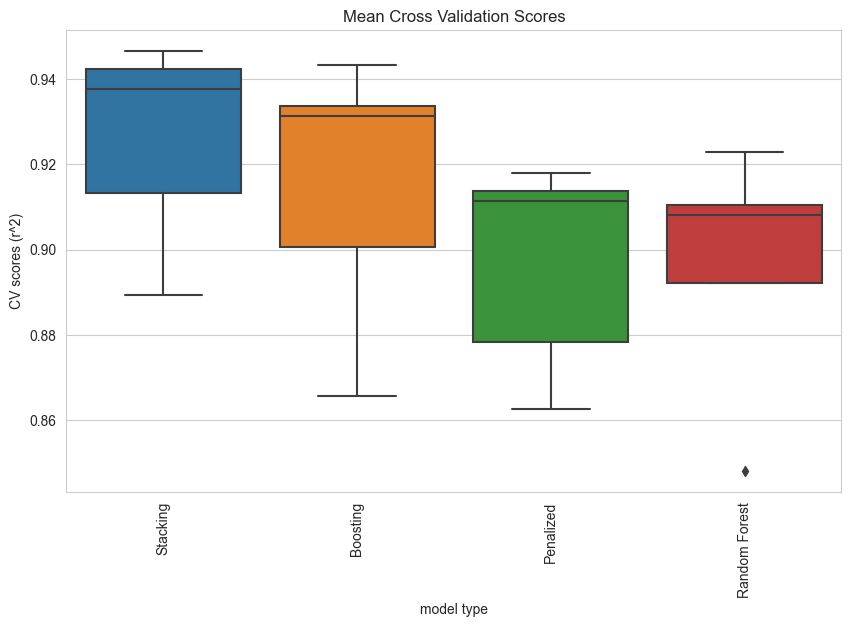

In [16]:
# rank model category by mean cv score
ranks = df_model_scores.groupby('model_type')['score'].median().sort_values(ascending=False).index

# plot box plots in order of median score
plt.figure(figsize=(10,6))
sns.boxplot(x='model_type', y='score', data=df_model_scores, order=ranks)
plt.title('Mean Cross Validation Scores')
plt.xlabel("model type")
plt.xticks(rotation=90)
plt.ylabel("CV scores (r^2)")
plt.show()